In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm

In [2]:
# loading the dataset
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

In [3]:
# top 5 rows of dataset
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


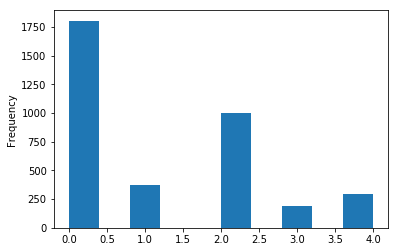

In [4]:
# distribution of classes in dataset ( which is imbalanced )
train_df['diagnosis'].plot(kind='hist')

In [5]:
# dimension of csv train file
train_df.shape

(3662, 2)

In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

### Preprocessing the Image :

In [ ]:
def preprocess_image(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

def preprocess_image1(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

In [8]:
N1 = train_df.shape[0]
x_train1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
for i, image_id in tqdm(enumerate((train_df['id_code']))):
    x_train1[i, :, :, :] = preprocess_image1(
        f'/kaggle/input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )    

3662it [11:11,  4.62it/s]


In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

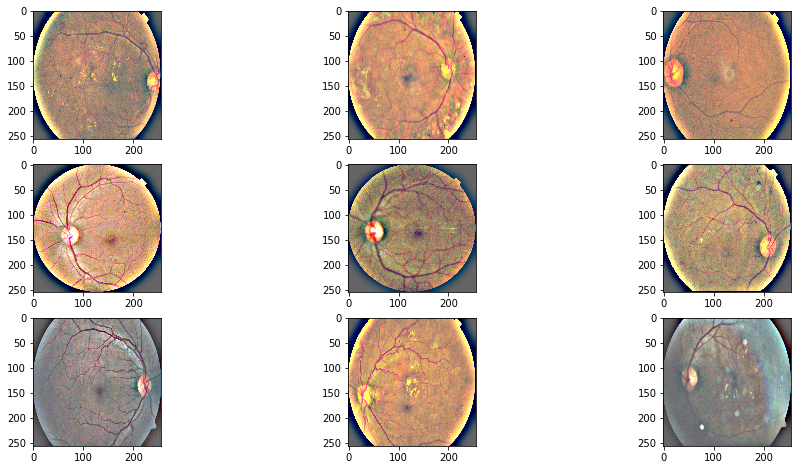

In [10]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train1[i])

In [11]:
del N1
gc.collect()

17136

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [13]:
np.save('y_train1.npy',y_train_multi)
np.save('x_train1.npy',x_train1)